In [1]:
# データの用意
import glob
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
IMG_SIZE = 224
x_train = np.empty([0, IMG_SIZE, IMG_SIZE, 3])
y_train = np.empty([0])
x_test = np.empty([0, IMG_SIZE, IMG_SIZE, 3])
y_test = np.empty([0])
for i in range(16):
    files = glob.glob(f'datas/major/{i}/*.jpg')
    imgs = np.array([img_to_array(load_img(f, color_mode='rgb', target_size=(IMG_SIZE,IMG_SIZE))) for f in files])
    labels = np.array([i for f in files])

    x_train = np.r_[x_train, imgs]
    y_train = np.r_[y_train, labels]

    files = glob.glob(f'datas/tests/{i}/*.jpg')
    imgs = np.array([img_to_array(load_img(f, color_mode='rgb', target_size=(IMG_SIZE,IMG_SIZE))) for f in files])
    labels = np.array([i for f in files])

    x_test = np.r_[x_test, imgs]
    y_test = np.r_[y_test, labels]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.33, shuffle= True)

d:\デスクトップ\workdir\DL4US_task\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\デスクトップ\workdir\DL4US_task\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\デスクトップ\workdir\DL4US_task\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\デスクトップ\workdir\DL4US_task\venv\lib\site-packages\tensorflow\python\framework

In [2]:
# データセットの大きさ確認
print(x_train.shape) # 訓練データのサイズ
print(y_train.shape) 
print(x_test.shape) # テストデータのサイズ
print(y_test.shape)
print(x_valid.shape)
print(y_valid.shape)
#(464, 224, 224, 3)

(1220, 224, 224, 3)
(1220, 16)
(310, 224, 224, 3)
(310, 16)
(154, 224, 224, 3)
(154, 16)


In [ ]:
# データセットの表示
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(120, 120))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(1, 9, i + 1, xticks=[], yticks=[])
    ax.imshow((x_train[i] * 255).astype(np.uint8))

In [11]:
# モデル構築 ふんわりCNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D

model = Sequential()

model.add(Convolution2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(364, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

# 出力層
model.add(Dense(16, activation='softmax'))

model.compile(loss="categorical_crossentropy", metrics = ["accuracy"], optimizer = "adam")

In [61]:
# モデル構築 DenseNet
from tensorflow.keras.applications import densenet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
base_model = densenet.DenseNet121(include_top=False, weights='imagenet', classes=1000)

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(16, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", metrics = ["accuracy"], optimizer = "adam")

In [5]:
# モデル構築 VGGNet16
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
import numpy as np

# VGG16のロード。FC層は不要なので include_top=False
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# VGG16の図の緑色の部分（FC層）の作成
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(16, activation='softmax'))

# VGG16とFC層を結合してモデルを作成（完成図が上の図）
model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

# VGG16の図の青色の部分は重みを固定（frozen）
for layer in model.layers[:15]:
    layer.trainable = False

# 多クラス分類を指定
model.compile(loss='categorical_crossentropy',
          optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
          metrics=['accuracy'])

In [62]:
# 学習
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

# data augmentationの設定
params = {
    'rotation_range': 30,
    'width_shift_range':0.4,
    'height_shift_range':0.4
}
datagen = image.ImageDataGenerator(**params)
datagen.fit(x_train)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

# history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=512), epochs=100, validation_data=(x_valid, y_valid), callbacks=[early_stopping])
model.fit(x_train, y_train, batch_size=128, verbose=2, epochs=30, validation_data=(x_valid, y_valid), callbacks=[early_stopping])

Train on 1220 samples, validate on 154 samples
Epoch 1/30
 - 11s - loss: 2.9927 - acc: 0.1172 - val_loss: 12.3705 - val_acc: 0.1104
Epoch 2/30
 - 5s - loss: 2.3960 - acc: 0.2721 - val_loss: 11.5605 - val_acc: 0.1039
Epoch 3/30
 - 5s - loss: 1.9559 - acc: 0.4090 - val_loss: 12.1084 - val_acc: 0.0909
Epoch 4/30
 - 5s - loss: 1.6573 - acc: 0.5189 - val_loss: 11.6290 - val_acc: 0.1169
Epoch 5/30
 - 5s - loss: 1.4242 - acc: 0.6230 - val_loss: 11.8157 - val_acc: 0.1234
Epoch 6/30
 - 5s - loss: 1.2568 - acc: 0.6541 - val_loss: 11.5093 - val_acc: 0.1039
Epoch 7/30
 - 5s - loss: 1.1437 - acc: 0.6943 - val_loss: 11.8160 - val_acc: 0.1039
Epoch 8/30
 - 5s - loss: 1.0314 - acc: 0.7402 - val_loss: 11.8376 - val_acc: 0.0974
Epoch 9/30
 - 5s - loss: 0.9420 - acc: 0.7516 - val_loss: 11.7589 - val_acc: 0.1104
Epoch 10/30
 - 5s - loss: 0.8741 - acc: 0.7705 - val_loss: 11.7115 - val_acc: 0.1104
Epoch 11/30
 - 5s - loss: 0.8091 - acc: 0.8000 - val_loss: 11.6852 - val_acc: 0.0909
Epoch 12/30
 - 5s - loss: 

In [57]:
# 性能評価
score = model.evaluate(x_test, y_test, verbose=0)
print(score)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

[13.858842295985069, 0.077419356]
Test loss: 13.858842295985069
Test accuracy: 0.077419356


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


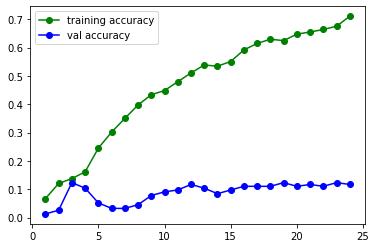

In [63]:
# 経過確認
import matplotlib.pyplot as plt
print(history.history.keys())
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'go-', label='training accuracy')
plt.plot(epochs, val_acc, 'bo-', label='val accuracy')
plt.legend()
plt.show()

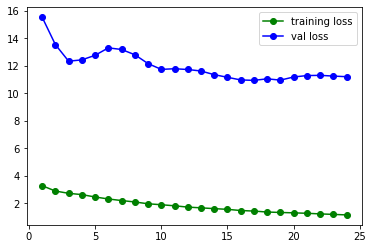

In [64]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1 )
plt.plot(epochs, loss, 'go-', label='training loss')
plt.plot(epochs, val_loss, 'bo-', label='val loss')
plt.legend()
plt.show()